<a href="https://colab.research.google.com/github/CodyBurker/W266_Group_Project/blob/CodyCNNBase/CNN-Balanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on: https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [1]:
import pandas as pd
import string
from nltk.corpus import stopwords
import nltk
import numpy as np

In [2]:
!git clone https://github.com/CodyBurker/W266_Group_Project

Cloning into 'W266_Group_Project'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 96 (delta 37), reused 32 (delta 5), pack-reused 0
Unpacking objects: 100% (96/96), done.
Checking out files: 100% (14/14), done.


In [11]:
X_train = pd.read_csv('W266_Group_Project/x_train_balanced.csv')
y_train = pd.read_csv('W266_Group_Project/y_train_balanced.csv')
X_test = pd.read_csv('W266_Group_Project/x_test_balanced.csv')
# y_test = pd.read_csv('W266_Group_Project/y_test_balanced.csv')
X_test = pd.read_csv('W266_Group_Project/x_test_sampled_yelp_data.csv')
y_test = pd.read_csv('W266_Group_Project/y_test_sampled_yelp_data.csv')

y_train = np.array(y_train.stars.astype('int')) - 1
y_test = np.array(y_test.stars.astype('int')) - 1

In [14]:
pd.DataFrame({'stars':y_train}).groupby(['stars']).size()

stars
0    15911
1    15991
2    16049
3    16067
4    15982
dtype: int64

In [15]:
pd.DataFrame({'stars':y_test}).groupby(['stars']).size()

stars
0    2967
1    1597
2    2117
3    4433
4    8886
dtype: int64

https://towardsdev.com/sentiment-analysis-with-cnn-using-keras-c4debff57fc5?gi=708b4ef40e2f

Encode text and pad it.

In [16]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['text'])


In [18]:
X_train['encoded'] = tokenizer.texts_to_sequences(X_train['text'])
X_test['encoded'] = tokenizer.texts_to_sequences(X_test['text'])

(array([45971., 22019.,  7220.,  2693.,  1085.,   491.,   244.,   126.,
           99.,    52.]),
 array([   1. ,  100.9,  200.8,  300.7,  400.6,  500.5,  600.4,  700.3,
         800.2,  900.1, 1000. ]),
 <a list of 10 Patch objects>)

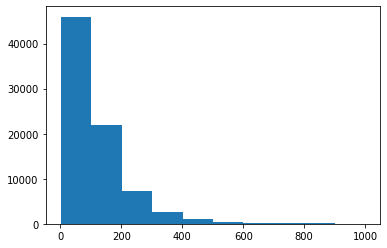

In [19]:
import matplotlib.pyplot as plt
plt.hist(X_train['encoded'].apply(len))

In [20]:
# Hyper parameters to tune later: maxlen, padding
sentence_len = 200
X_train_encoded =  pad_sequences(X_train['encoded'], maxlen=sentence_len, padding='post', truncating='post')
X_test_encoded = pad_sequences(X_test['encoded'], maxlen=sentence_len, padding='post', truncating = 'post')
print(X_train_encoded.shape)
print(X_test_encoded.shape)

(80000, 200)
(20000, 200)


Create model

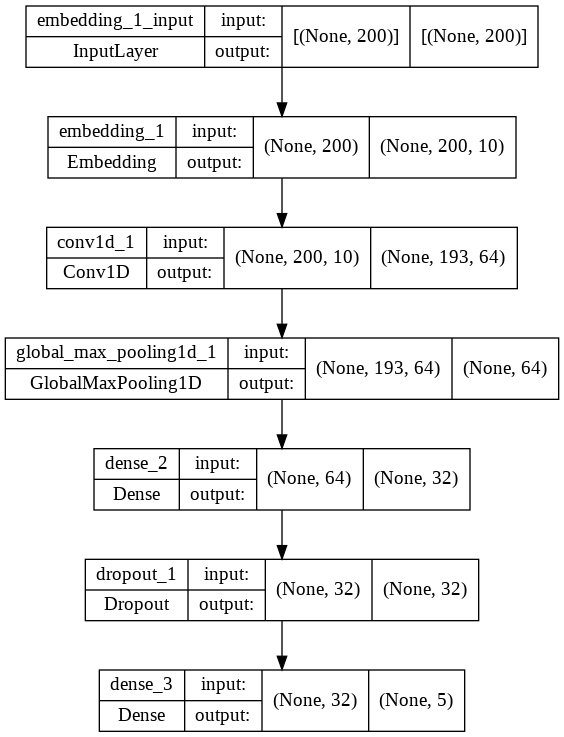

In [31]:
from keras.layers.pooling import GlobalMaxPool1D
from keras import Sequential
from keras.layers import Dense, Embedding, Activation, Dropout
from keras.layers import  MaxPool1D, GlobalMaxPool1D, Conv1D
vocab_size = len(tokenizer.word_counts)
# New model architecture
model2 = Sequential()
model2.add(Embedding(vocab_size,10, input_length = sentence_len))
model2.add(Conv1D(64,8,activation="relu"))
model2.add(GlobalMaxPool1D())
model2.add(Dense(32, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(5,activation='softmax'))
# model2.add(Dense(1,activation='relu'))
from keras.utils.vis_utils import plot_model
model2.compile(optimizer='sgd', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
plot_model(model2,show_shapes=True)


In [32]:
from keras.callbacks import EarlyStopping
# callback = EarlyStopping(monitor='val_accuracy', patience=15)

history = model2.fit(X_train_encoded,y_train,
           epochs=150,
           batch_size=128, 
           validation_data = [X_test_encoded, y_test],
          #  callbacks = [callback]
           )

Epoch 1/150
625/625 [==============================] - 3s 4ms/step - loss: 1.6094 - accuracy: 0.2007 - val_loss: 1.6078 - val_accuracy: 0.2389
Epoch 2/150
625/625 [==============================] - 2s 3ms/step - loss: 1.6088 - accuracy: 0.2068 - val_loss: 1.6110 - val_accuracy: 0.1493
Epoch 3/150
625/625 [==============================] - 2s 3ms/step - loss: 1.6084 - accuracy: 0.2152 - val_loss: 1.6092 - val_accuracy: 0.2046
Epoch 4/150
625/625 [==============================] - 2s 3ms/step - loss: 1.6081 - accuracy: 0.2177 - val_loss: 1.6081 - val_accuracy: 0.2347
Epoch 5/150
625/625 [==============================] - 2s 3ms/step - loss: 1.6078 - accuracy: 0.2254 - val_loss: 1.6080 - val_accuracy: 0.2022
Epoch 6/150
625/625 [==============================] - 2s 3ms/step - loss: 1.6073 - accuracy: 0.2263 - val_loss: 1.6088 - val_accuracy: 0.2394
Epoch 7/150
625/625 [==============================] - 2s 3ms/step - loss: 1.6070 - accuracy: 0.2291 - val_loss: 1.6060 - val_accuracy: 0.2907

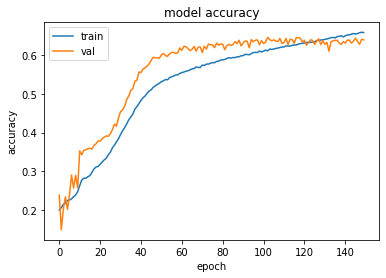

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

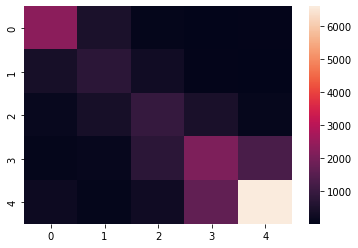

In [34]:
# Generate confusion matrix on test set
test_preds = model2.predict(X_test_encoded)
test_preds_stars = test_preds.argmax(axis=1) + 1
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test + 1, test_preds_stars)
import seaborn as sns
sns.heatmap(cf)

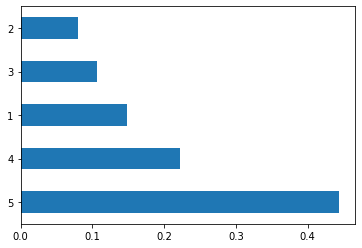

In [35]:
y_test_pd = pd.DataFrame({'stars':y_test})
y_test_pd.stars = y_test_pd.stars + 1
# freq = y_test_pd.groupby(['stars']).size()
(y_test_pd.stars.value_counts() / len(y_test_pd)).plot.barh()